# Project Notes

Investigate feasibility of using wifi fingerprinting to determine a person's location indoors using signal
strength of wireless access points (WAPs). We have been provided with a large database of wifi fingerprints 
for a multi-building campus with a location associated with each fingerprint.
Task is to evaluate multiple machine learning algorithms to determine which produces the best result and
make recommendations to the client regarding the best model.

DataSource: Joaquín Torres-Sospedra, Raúl Montoliu, Adolfo Martínez-Usó, Tomar J. Arnau, Joan P. Avariento, Mauri Benedito-Bordonau, Joaquín Huerta UJIIndoorLoc: A New Multi-building and Multi-floor Database for WLAN Fingerprint-based Indoor Localization Problems In Proceedings of the Fifth International Conference on Indoor Positioning and Indoor Navigation, 2014. 

https://archive.ics.uci.edu/ml/datasets/ujiindoorloc

# Load Packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import warnings
warnings.filterwarnings('ignore')

# Load and Evaluate Data

In [41]:
#data
dataset = pd.read_csv("trainingData.csv")

print(dataset.shape)

(19937, 529)


In [4]:
# types
set_option('display.max_rows', 25) 
print(dataset.dtypes)

WAP001                int64
WAP002                int64
WAP003                int64
WAP004                int64
WAP005                int64
WAP006                int64
WAP007                int64
WAP008                int64
WAP009                int64
WAP010                int64
WAP011                int64
WAP012                int64
                     ...   
WAP518                int64
WAP519                int64
WAP520                int64
LONGITUDE           float64
LATITUDE            float64
FLOOR                 int64
BUILDINGID            int64
SPACEID               int64
RELATIVEPOSITION      int64
USERID                int64
PHONEID               int64
TIMESTAMP             int64
Length: 529, dtype: object


In [5]:
# head
set_option('display.width', 100) 
print(dataset.head(20))

    WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  WAP010     ...      \
0      100     100     100     100     100     100     100     100     100     100     ...       
1      100     100     100     100     100     100     100     100     100     100     ...       
2      100     100     100     100     100     100     100     -97     100     100     ...       
3      100     100     100     100     100     100     100     100     100     100     ...       
4      100     100     100     100     100     100     100     100     100     100     ...       
5      100     100     100     100     100     100     100     100     100     100     ...       
6      100     100     100     100     100     100     100     100     100     100     ...       
7      100     100     100     100     100     100     100     100     100     100     ...       
8      100     100     100     100     100     100     100     100     100     100     ...       
9      100     100  

In [6]:
# Response variables in our problem are Building, Floor, Latitude, Longitude and Relative Position
(dataset[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']]
.astype(str)
.describe(include=['object']))

,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID
count,19937,19937,19937,19937,19937,19937
unique,5,3,123,2,18,16
top,3,2,202,2,11,14
freq,5048,9492,484,16608,4516,4835


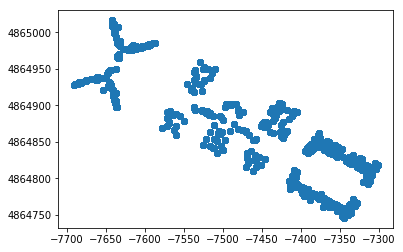

In [45]:
#Physical plot of the data by longitude and latitude showing three buildings
x = dataset['LONGITUDE']
y = dataset['LATITUDE']
pyplot.scatter(x,y)
pyplot.show()

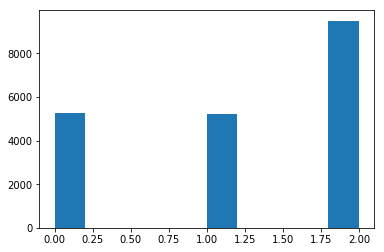

In [10]:
pyplot.hist(dataset['BUILDINGID'])
pyplot.show()



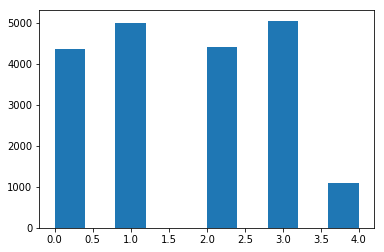

In [11]:
pyplot.hist(dataset['FLOOR'])
pyplot.show()

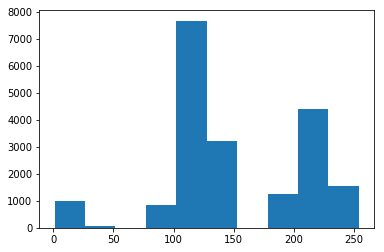

In [12]:
pyplot.hist(dataset['SPACEID'])
pyplot.show()

# Preprocessing

 Focusing on Floor BuildingID and SpaceID predicted on 520 WAPs on 3 buildings so delete other variables

In [7]:
del dataset ['LONGITUDE']
del dataset ['LATITUDE']
del dataset ['RELATIVEPOSITION']
del dataset ['USERID']
del dataset ['PHONEID']
del dataset ['TIMESTAMP']


In [9]:
print(dataset.shape)

(19937, 523)


In [13]:
#features
features = dataset.iloc[:,0:520]
print('Summary of feature sample')
features.head()

Summary of feature sample


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
2,100,100,100,100,100,100,100,-97,100,100,...,100,100,100,100,100,100,100,100,100,100
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [46]:
#dependent variable set to SPACEID for this particular task
depVar = dataset['SPACEID']
depVar.head()

0    106
1    106
2    103
3    102
4    122
Name: SPACEID, dtype: int64

# Train/test sets

In [15]:
#Training Set (Feature Space: X Training)
X_train = (features[: 5000])
X_train.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
2,100,100,100,100,100,100,100,-97,100,100,...,100,100,100,100,100,100,100,100,100,100
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [16]:
#Dependent Variable Training Set (Y Training)
Y_train = depVar[: 5000]
Y_train_count = len(Y_train.index)
print('The number of observations in the Y training set are:',str(Y_train_count))
Y_train.head()

The number of observations in the Y training set are: 5000


0    106
1    106
2    103
3    102
4    122
Name: SPACEID, dtype: int64

In [17]:
#Testing Set (X Testing)
X_test = features[-1500:]
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
print(X_test.head())

The number of observations in the feature testing set is: 1500
       WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  WAP010   ...    \
18437     100     100     100     100     100     100     100     100     100     100   ...     
18438     100     100     100     100     100     100     100     100     100     100   ...     
18439     100     100     100     100     100     100     100     100     100     100   ...     
18440     100     100     100     100     100     100     100     100     100     100   ...     
18441     100     100     100     100     100     100     100     100     100     100   ...     

       WAP511  WAP512  WAP513  WAP514  WAP515  WAP516  WAP517  WAP518  WAP519  WAP520  
18437     100     100     100     100     100     100     100     100     100     100  
18438     100     100     100     100     100     100     100     100     100     100  
18439     100     100     100     100     100     100     100     100     100     100  
18

In [18]:
#Ground Truth (y_test) 
Y_test = depVar[-1500:]
Y_test_count = len(Y_test.index)
print('The number of observations in the Y training set are:',str(Y_test_count))
Y_test.head()

The number of observations in the Y training set are: 1500


18437    114
18438    115
18439    117
18440    121
18441    118
Name: SPACEID, dtype: int64

In [19]:
# Split-out validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train)
X_train.shape, X_test.shape

((3750, 520), (1250, 520))

# Use 10-fold cross validation to estimate accuracy.

In [20]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

# Build Models. Evaluate six algorithms including simple linear(LR and LDA) and 4 nonlinear.

In [21]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB())) 
models.append(('SVM', SVC()))

# Train suite of algorithms and select best models. 

In [22]:
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.500000 (0.030921)
LDA: 0.467467 (0.025074)
KNN: 0.610667 (0.023551)
CART: 0.604533 (0.033372)
NB: 0.358933 (0.020490)
SVM: 0.115733 (0.017331)


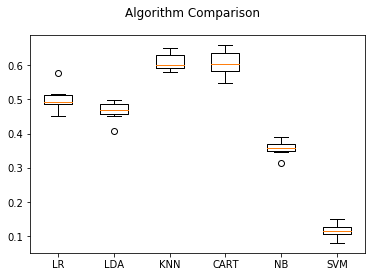

In [23]:
# Compare Algorithms
fig = pyplot.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
pyplot.boxplot(results) 
ax.set_xticklabels(names)
pyplot.show()

# Stardardize dataset and rerun algorithms to evaluate improvement.

In [24]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())]))) 
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: 0.578400 (0.014481)
ScaledLDA: 0.467467 (0.025074)
ScaledKNN: 0.578400 (0.023169)
ScaledCART: 0.598400 (0.027200)
ScaledNB: 0.361333 (0.021836)
ScaledSVM: 0.431733 (0.013304)


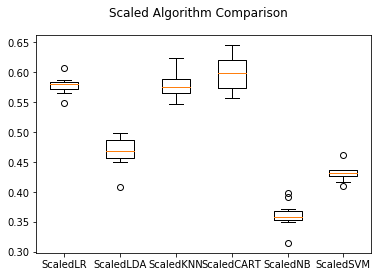

In [25]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison') 
ax = fig.add_subplot(111) 
pyplot.boxplot(results) 
ax.set_xticklabels(names)
pyplot.show()

# Tune a couple of algorithms to see if results improve.

In [26]:
# Tune scaled KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,5,10,15,21,25]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.668267 using {'n_neighbors': 1}
0.668267 (0.008940) with: {'n_neighbors': 1}
0.455733 (0.012979) with: {'n_neighbors': 15}
0.412000 (0.013971) with: {'n_neighbors': 21}
0.380267 (0.011451) with: {'n_neighbors': 25}


In [27]:
# Tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.5, 1.0, 1.5]
kernel_values = ['linear', 'poly','rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold) 
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.640800 using {'C': 0.1, 'kernel': 'linear'}
0.640800 (0.014608) with: {'C': 0.1, 'kernel': 'linear'}
0.064267 (0.016800) with: {'C': 0.1, 'kernel': 'poly'}
0.065067 (0.012632) with: {'C': 0.1, 'kernel': 'rbf'}
0.069067 (0.014333) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.636267 (0.017331) with: {'C': 0.5, 'kernel': 'linear'}
0.139467 (0.019489) with: {'C': 0.5, 'kernel': 'poly'}
0.294667 (0.017333) with: {'C': 0.5, 'kernel': 'rbf'}
0.216533 (0.018544) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.634133 (0.014886) with: {'C': 1.0, 'kernel': 'linear'}
0.176533 (0.021159) with: {'C': 1.0, 'kernel': 'poly'}
0.431733 (0.014676) with: {'C': 1.0, 'kernel': 'rbf'}
0.308533 (0.024001) with: {'C': 1.0, 'kernel': 'sigmoid'}
0.635467 (0.015778) with: {'C': 1.5, 'kernel': 'linear'}
0.198667 (0.019569) with: {'C': 1.5, 'kernel': 'poly'}
0.504800 (0.008267) with: {'C': 1.5, 'kernel': 'rbf'}
0.370133 (0.019406) with: {'C': 1.5, 'kernel': 'sigmoid'}


# Train ensembles and compare

In [28]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier())) 
ensembles.append(('GBM', GradientBoostingClassifier())) 
ensembles.append(('RF', RandomForestClassifier())) 
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

AB: 0.045333 (0.010865)
GBM: 0.602933 (0.016328)
RF: 0.722667 (0.024585)


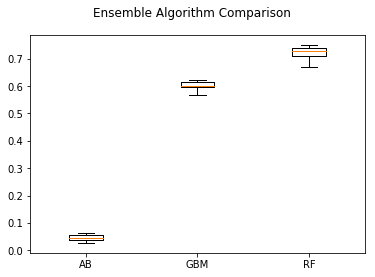

In [29]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison') 
ax = fig.add_subplot(111) 
pyplot.boxplot(results) 
ax.set_xticklabels(names)
pyplot.show()

RandomForest ensemble was the best performing algorithm on the training data so will use it to make predictions.

# Make Predictions

In [34]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)
predictions = RF.predict(X_test)
predAccuracy = accuracy_score(Y_test,predictions)
print('Accuracy: %.3f' % predAccuracy)
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

Accuracy: 0.735
[[14  0  0 ...  0  0  0]
 [ 1  8  0 ...  0  0  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  3]]
              precision    recall  f1-score   support

           2       0.93      1.00      0.97        14
           3       0.89      0.80      0.84        10
           4       0.88      1.00      0.93         7
           5       1.00      0.83      0.91        12
           6       0.80      1.00      0.89         8
           7       1.00      1.00      1.00         8
           8       0.71      0.71      0.71         7
           9       0.60      0.75      0.67         8
          10       1.00      0.82      0.90        17
          15       1.00      0.83      0.91         6
          16       1.00      1.00      1.00         5
          17       1.00      0.78      0.88         9
          18       0.43      1.00      0.60         3
          22       1.00      1.00      1.00         3
          26     

In [38]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)
predictions = RF.predict(X_test)
predKappa = cohen_kappa_score(Y_test,predictions)
print('Kappa: %.3f' % predKappa)

Kappa: 0.744


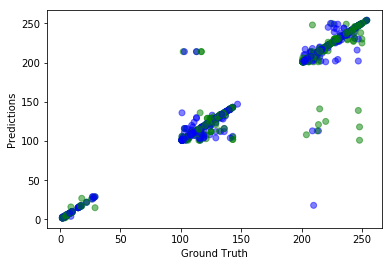

In [48]:
from matplotlib import pyplot as plt
plt.scatter(Y_test, predictions, color=['blue','green'], alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show();